# Data Mining Final Project 2021 - 2022
## Authors: Beatriz Gonçalves (m20210695), Diogo Hipólito (m20210633) and Diogo Pereira (m20210657)

# 1) Introduction

The client, a Marketing Department from an an insurance company, wishes to better understand the scope of its clients, in order to better serve them and increase their ROI (Return On Investment). The group was given an ABT (Analytic Based Table), consisting of 10.290 customers and given the task of analyzing the table for evident groups of clusters, extracting the behaviour of said clusters and provide insights on how to better serve them.

The project is contained within a Github repository which can be accessed through the following link: https://github.com/beatrizctgoncalves/project_dm. This repository provides a Jupyter Notebook with all the relevant analysis and a report that summarizes the work done. Note that these two documents should be used together as they complement each other.

References: <br>
(1) https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/ <br>
(2) https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb <br>
(3) https://towardsdatascience.com/gmm-gaussian-mixture-models-how-to-successfully-use-it-to-cluster-your-data-891dc8ac058f <br>
(4) https://towardsdatascience.com/digital-tribes-customer-clustering-with-k-means-6db8580a7a60 <br>
(5) https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945 <br>

## 1.1) Importing Packages

In [256]:
# Required imports for the project
#!pip install sas7bdat

from sas7bdat import SAS7BDAT
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import iqr
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ward
from kmodes.kprototypes import KPrototypes
from scipy.spatial.distance import pdist,cdist
from pandas.plotting import parallel_coordinates


from yellowbrick.cluster import KElbowVisualizer

# 2) Importing and Assessing Data

In [257]:
df_insurance = pd.read_sas('a2z_insurance.sas7bdat')
conn = sqlite3.connect('a2z_insurance.db')
cursor = conn.cursor()

# Build Analytical Base Table (ABT)
df_insurance.to_sql(name='file', con=conn, if_exists='replace', index=False)

In [258]:
# Dataset head
df_insurance.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [259]:
df_insurance.set_index("CustID",inplace=True)

In [260]:
# Get dimension of the dataset
df_insurance.shape

(10296, 13)

In [261]:
# Get data types and 
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [262]:
# Check for duplicates
df_insurance.duplicated().sum()

3

In [263]:
#Seems like there are 3 duplicates in our data, let's remove them
df_insurance = df_insurance[df_insurance.duplicated()==False]

In [264]:
df_insurance = df_insurance.astype({"GeoLivArea": object, "Children": object})

In [265]:
df_insurance["EducDeg"] = df_insurance["EducDeg"].astype("category").cat.rename_categories({b'1 - Basic':'1',b'2 - High School':'2',b'3 - BSc/MSc':'3',b'4 - PhD':'4'}).cat.reorder_categories(['1','2','3','4'])

In [266]:
#First divide the variables into metric and non-metric
non_metric_features = ["EducDeg","GeoLivArea","Children"]
metric_features = df_insurance.columns.difference(non_metric_features)

print("Non metric features: ")
print(non_metric_features)

print("Metric features: ")
print(metric_features)

Non metric features: 
['EducDeg', 'GeoLivArea', 'Children']
Metric features: 
Index(['BirthYear', 'ClaimsRate', 'CustMonVal', 'FirstPolYear', 'MonthSal',
       'PremHealth', 'PremHousehold', 'PremLife', 'PremMotor', 'PremWork'],
      dtype='object')


In [267]:
desc_num = df_insurance[metric_features].describe().T
missing = df_insurance.isnull().sum(axis=0)
desc_num["missing values"] = missing

desc_num

,count,mean,std,min,25%,50%,75%,max,missing values
BirthYear,10276.0,1968.006909,19.710742,1028.00,1953.00,1968.00,1983.00,2001.00,17
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20,0
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89,0
FirstPolYear,10263.0,1991.064893,511.342617,1974.00,1980.00,1986.00,1992.00,53784.00,30
MonthSal,10257.0,2506.618699,1157.518390,333.00,1706.00,2502.00,3290.00,55215.00,36
PremHealth,10250.0,171.553183,296.444399,-2.11,111.80,162.81,219.04,28272.00,43
PremHousehold,10293.0,210.419863,352.635041,-75.00,49.45,132.80,290.05,25048.80,0
PremLife,10189.0,41.848724,47.484264,-7.00,9.89,25.56,57.79,398.30,104
PremMotor,10259.0,300.501550,211.937740,-4.11,190.59,298.61,408.30,11604.42,34
PremWork,10207.0,41.283712,51.519022,-12.00,10.67,25.67,56.79,1988.70,86


Problematic values:
- BirthYear: min = 1028. That is impossible, that person would have to be almost 1000 years old
- FirstPolYear: max = 53784. Impossible, there can't be data from the future
- Every other variable: Looks like there are a lot of outliers. The difference between the 75th percentile and the max is signficant, so does between the 25th percentile and the min.

Missing values: We will have to decide later on how to deal with the missing values, the PremLife variable specifically has a lot of missing values (104).

In [268]:
desc_cat= df_insurance[non_metric_features].describe().T
mode = df_insurance[non_metric_features].mode().T
desc_cat["mode"] = mode
desc_cat["missing values"] = missing
desc_cat

,count,unique,top,freq,mode,missing values
EducDeg,10276,4,3,4799,3,17
GeoLivArea,10292.0,4.0,4.0,4142.0,4.0,1
Children,10272.0,2.0,1.0,7260.0,1.0,21


There are some missing values, but nothing worrying

### 2.1) Metric Variables' Correlation Matrix

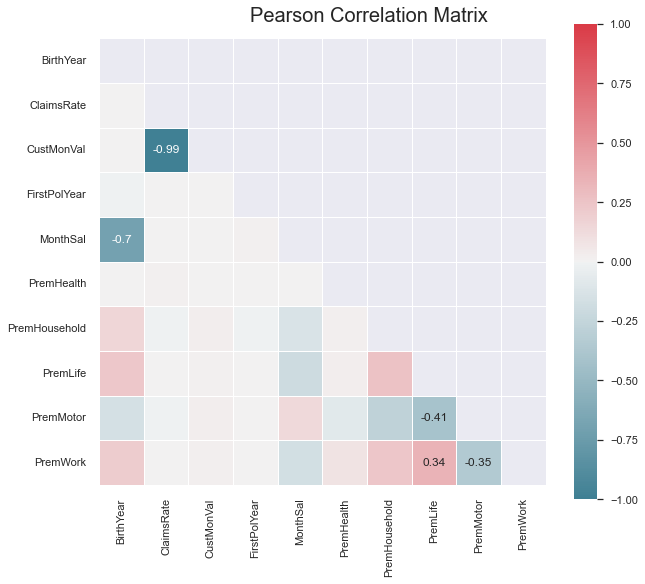

In [269]:
# Prepare figure
metric_features = df_insurance.columns.difference(non_metric_features)
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix
corr = np.round(df_insurance[metric_features].corr(method="pearson"), decimals=2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Build annotation matrix 
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, mask=mask)

# Layout
fig.subplots_adjust(top=0.95)
title = "Pearson Correlation Matrix"
fig.suptitle(title, fontsize=20)

plt.show()

A correlation matrix can show us which variables have the most potential for future modelling. <br>
Main takeaways: <br>
 - There is a really high correlation between ClaimsRate and CustMonVal, in fact it is almost a perfectly negative correlation. Which would mean that with one variable we can predict the value of the other. However, looking at the problem description, it does not initially look like one variable was created using the other. According to the description, CustMonVal = Total profit from customer * number of years as customer, and ClaimsRate = Amount paid by insurance / Premiums. In the future we will decide if we keep both columns. <br>
 - Other than that, there isn't any meaningful correlation between any of the variables, which is not a good start for our model.<br>
 - We will have to go through a deep data preparation process in order to have a workable dataset. <br>

# 3) Data Cleaning

## 3.1) Verify Coherence
This section's goal is to verify if all the data makes logical sense.
The logical rules that we want to clarify are:
* Are there client whose first policy predates their birth year?
* Are there minors with children?
* Are there minors with car insurance? 
* Are there customers older than 120 or not born yet?
<br/>
<br/>
As can be seen in the code below we test this conditions.

In [270]:
policy_before_birth = future_dates = df_insurance.loc[df_insurance["FirstPolYear"] < df_insurance["BirthYear"]]
print(f"Number of first policies before birth: {policy_before_birth.shape[0]}")

minors_with_children = df_insurance.loc[(df_insurance["BirthYear"] >= 1999) & (df_insurance["Children"]==1)]
print(f"Number of minors with children: {minors_with_children.shape[0]}")

minors_with_cars = df_insurance.loc[(df_insurance["BirthYear"] >= 1999) & (df_insurance["PremWork"]>0)]
print(f"Number of minors with cars: {minors_with_cars.shape[0]}")

invalid_birth = df_insurance.loc[(df_insurance["BirthYear"] > 2016) | (df_insurance["BirthYear"] < 1896)]
print(f"Number of invalid birth years: {invalid_birth.shape[0]}")

invalid_pol = df_insurance.loc[(df_insurance["FirstPolYear"] > 2016) | (df_insurance["FirstPolYear"] < 1896)]
print(f"Number of invalid first policy years: {invalid_pol.shape[0]}")

Number of first policies before birth: 1997
Number of minors with children: 87
Number of minors with cars: 114
Number of invalid birth years: 1
Number of invalid first policy years: 1


All sanity checks of the the birth year variable have failed significantly. The amount of erros in this variable is too significant for us to use it in the future, therefore we will drop the column "BirthYear".

In [271]:
df_insurance.drop(columns=["BirthYear"],inplace=True)
metric_features = metric_features.drop("BirthYear")

## 3.1) Outliers

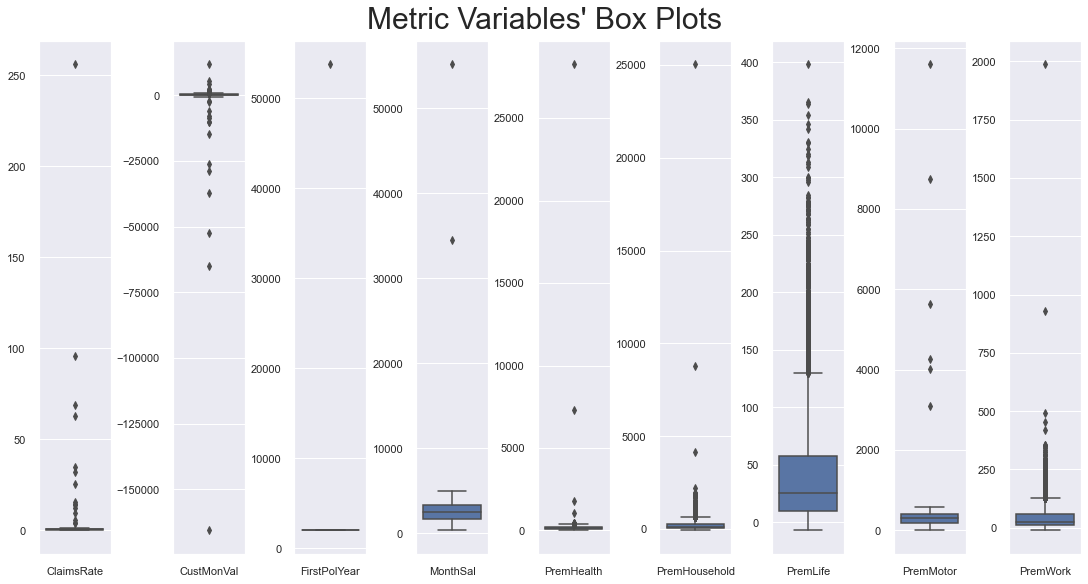

In [272]:
def boxplot(df_metric_features):
    # All Metric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure
    # Prepare dataframe layout:
    data = df_metric_features.melt()
    plot_features = metric_features
    #Prepare figure layout:
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15, 8), constrained_layout=True)

    # Plot data
    # Draw the box plots:
    for i in zip(axes, plot_features):
        sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0])
        i[0].set_xlabel("")
        i[0].set_ylabel("")

    # Layout
    # Add a centered title to the figure:
    title = "Metric Variables' Box Plots"
    plt.suptitle(title, fontsize=30)

    plt.show()

boxplot(df_insurance[metric_features])

Manual outlier removal

In [273]:
# First we remove unreasonable values
def remove_outliers(df):
    filters = (
        (df["ClaimsRate"] > 4)
        |
        (df["CustMonVal"] < -2000)
        |
        (df["FirstPolYear"] > 2017)
        |
        (df["MonthSal"] > 30000)
        |
        (df["PremHealth"] > 5000)
        |
        (df["PremHousehold"] > 4000)
        |
        (df["PremMotor"] > 2000)
        |
        (df["PremWork"] > 750)
        )
    outliers = df[filters]
    return df.drop(outliers.index),outliers

df_manual,outliers = remove_outliers(df_insurance)
print("Percentage of data kept after removing outliers: "
      + str(round(df_manual.shape[0] / df_insurance.shape[0], 4)))


Percentage of data kept after removing outliers: 0.9971


In [274]:
df_insurance = df_manual.copy()

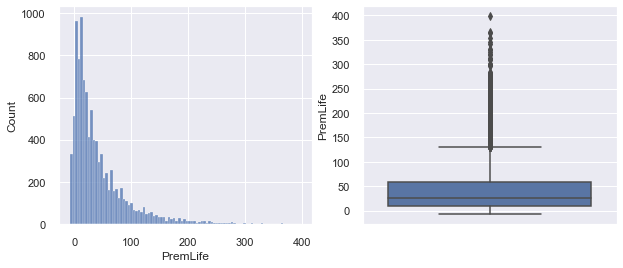

In [275]:
def check_outliers(df,variable):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(x=variable,data=df,ax=ax1)
    sns.boxplot(y=variable,data=df,ax=ax2)
    
check_outliers(df_manual,"PremLife")

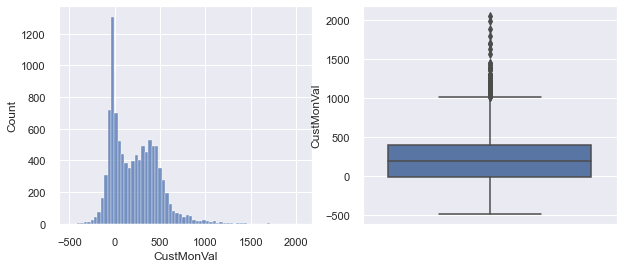

In [276]:
check_outliers(df_insurance,"CustMonVal")

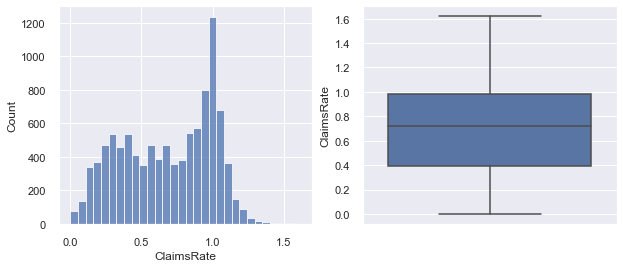

In [277]:
check_outliers(df_insurance,"ClaimsRate")

## 3.2) Missing values

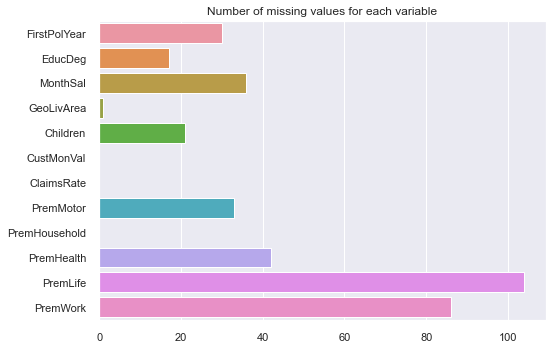

In [278]:
#Let's see how many values are missing for each variable
def count_missing(df):
    missing = df.isna().sum()
    sns.barplot(x=missing.values,y=missing.index)
    plt.title("Number of missing values for each variable")

    plt.show()
    
count_missing(df_insurance)

Most of the missing values are on the "PremLife" and "PremWork" variables. <br>
Do the missing values in the premium columns represent zeros? <br>
We need to see how many zero values are on each of the premium variables. <br>

In [279]:
# Set a variable with the columns related to premiums for future use
premiums = ["PremMotor","PremHealth","PremLife","PremWork","PremHousehold"]

The column PremHousehold has a total amount of 60 zero values


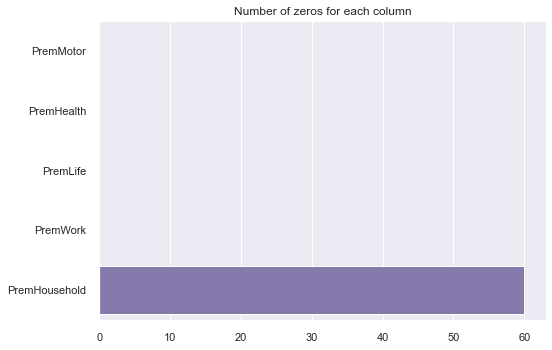

In [280]:
# For each premium column, we will count the occurences of zero values 
names = []
zeros = []
for i in df_insurance[premiums]:
    name = i 
    total = sum(df_insurance[i] == 0)
    
    if(total > 0):
        print(f"The column {i} has a total amount of {total} zero values")
    
    names.append(name)
    zeros.append(total)
    
sns.barplot(x=zeros,y=names)
plt.title("Number of zeros for each column")
plt.show()

The only Premium variable with zero values is PremHousehold, with 60 total zero values. <br>
There are two options to consider: <br>
- Zeros represent missing values - if so, why are they only present in "PremiumHousehold"?
- Missing values mean zero - why is this not applied in "PremiumHousehold" then?

We also need to consider the fact that we have already encountered errors previously, with the BirthYear variable, so we know the integrity of the dataset is dubious. <br>

Given all these factors, we will not replace the missing values with 0, instead we will use an independent approach, impute the missing values with the mean of its neighbors uisng KNNImputer.

In [281]:
knn_imputer = KNNImputer()
df_num_imputed = pd.DataFrame(knn_imputer.fit_transform(df_insurance[metric_features]),columns=df_insurance[metric_features].columns)

For categorical features, we cannot use the mean as the imputer metric. So we will use Simple Imputer for categorical variables, which will replace missing values with the mode of each variable.

In [282]:
simple_imputer = SimpleImputer(strategy="most_frequent")
df_cat_imputed = pd.DataFrame(simple_imputer.fit_transform(df_insurance[non_metric_features]), columns = df_insurance[non_metric_features].columns)

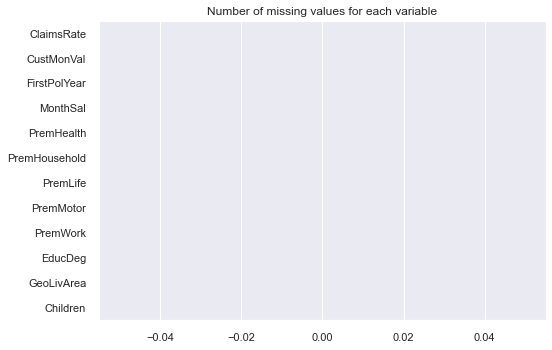

In [283]:
#After imputing the numeric and categorical features, we need to merge both dataframes.
df_imputed = df_num_imputed.join(df_cat_imputed)
count_missing(df_imputed)

Looks like the imputers were successful, there are no missing values remaining in our dataframe.

In [284]:
#Set the dataframe without missing values as the main dataframe
df_insurance = df_imputed.copy()

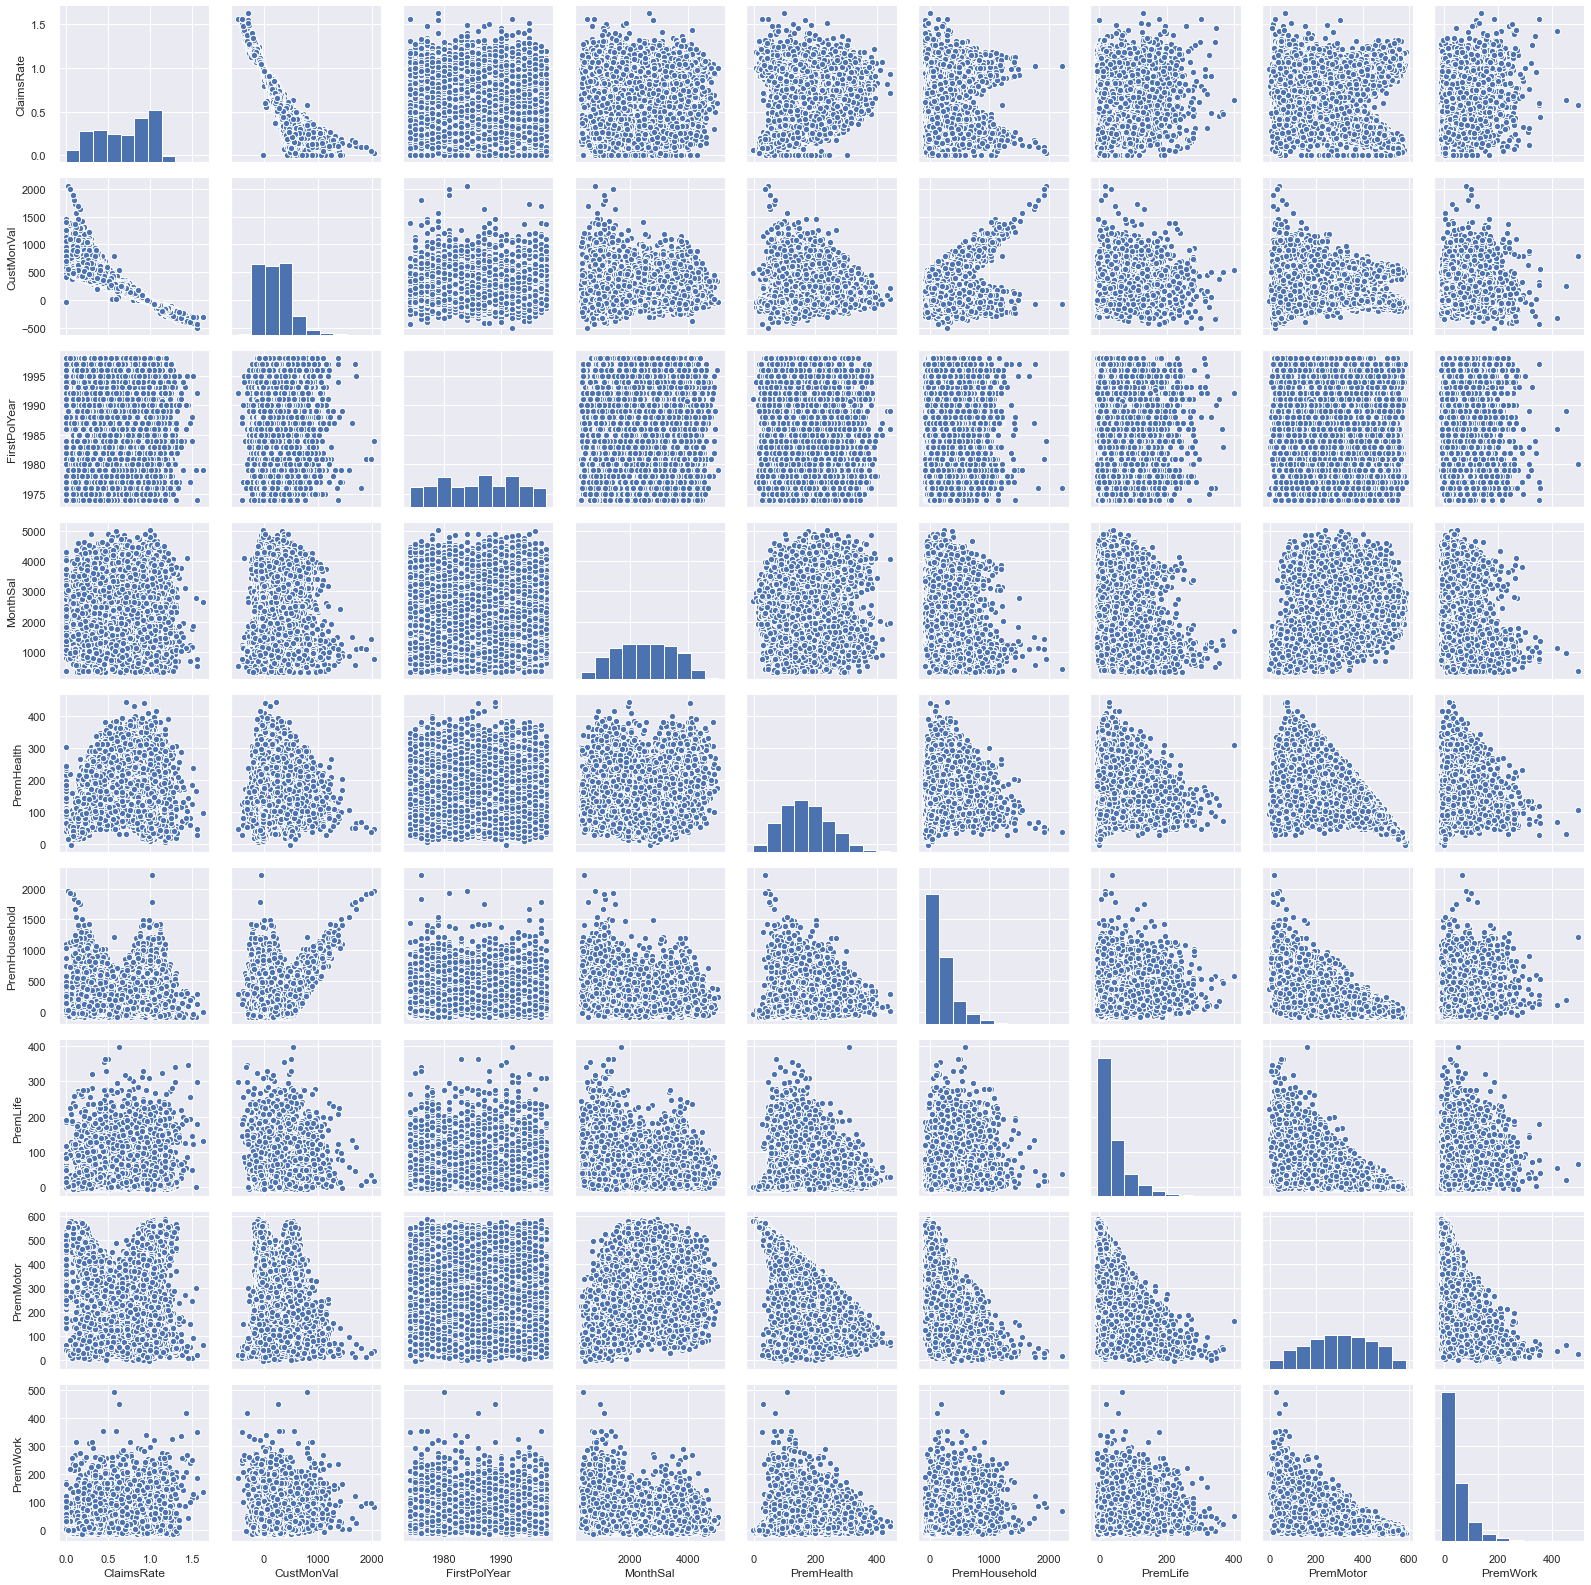

In [285]:
g = sns.PairGrid(df_insurance[metric_features])
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

## Non metric variables

Since we have only 3 categorical variables, we can plot their significance using just one plot, composed by multiple suplots. We will use pointplots, which are typically used for focusing comparisons between different levels of one or more categorical variables.

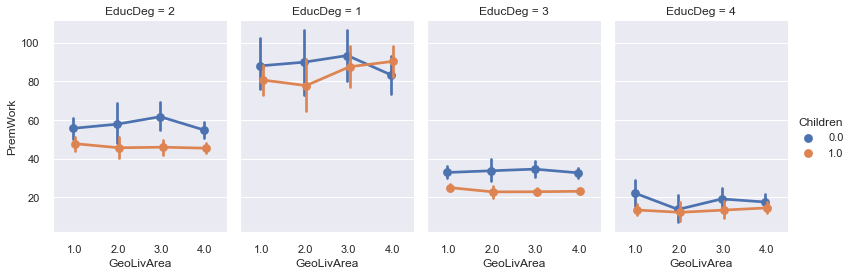

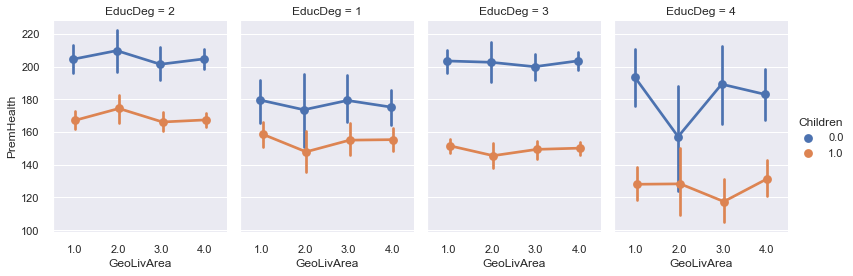

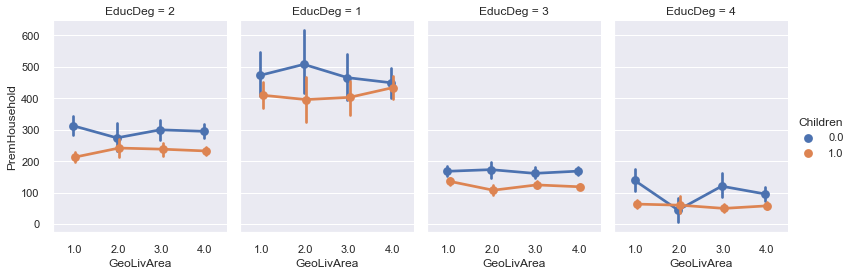

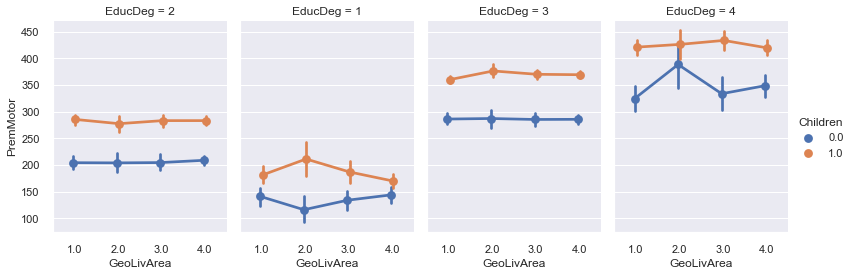

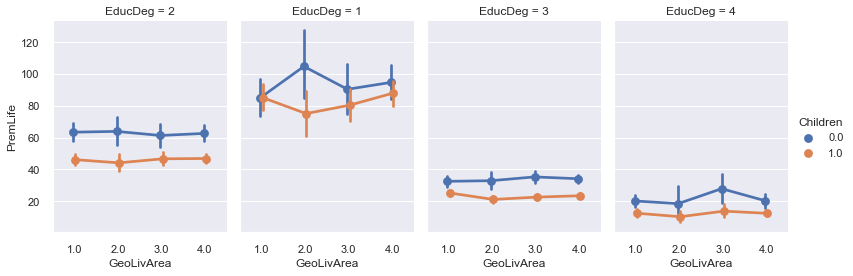

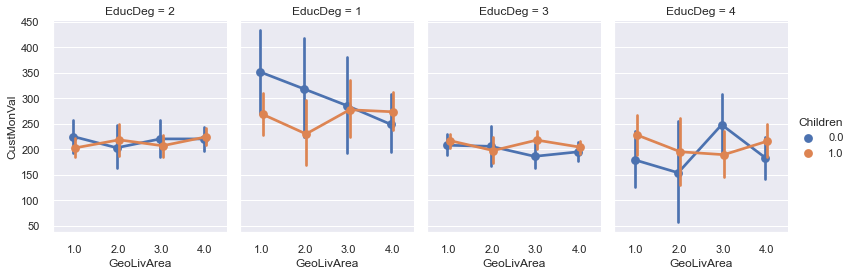

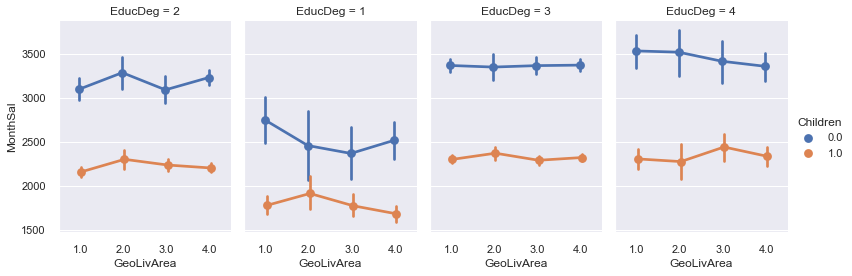

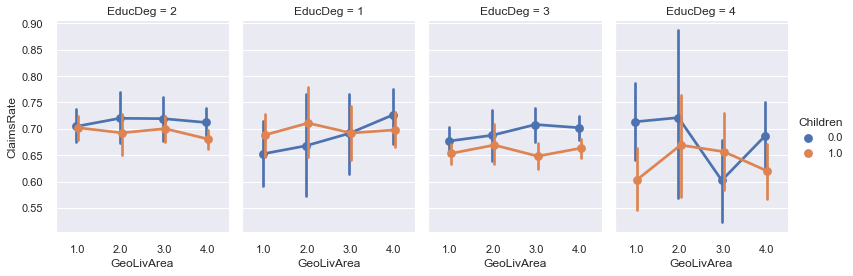

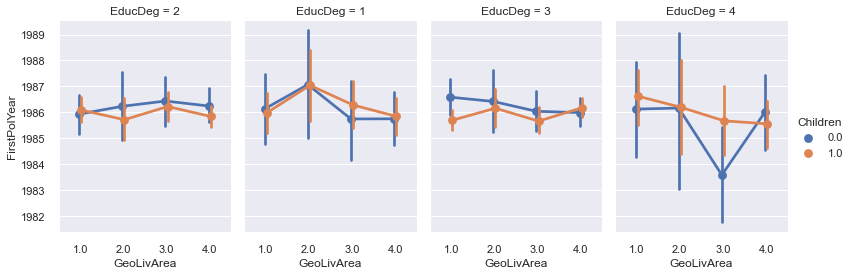

In [286]:
variables = ["PremWork","PremHealth","PremHousehold","PremMotor","PremLife",
             "CustMonVal","MonthSal","ClaimsRate","FirstPolYear"]
for i in variables:
    g = sns.catplot(x="GeoLivArea", y=i,

                hue="Children", col="EducDeg",

                data=df_insurance, kind="point",

                dodge=True,

                height=4, aspect=.7);

plt.show()

Comments:
- Children: 
 - Clear effect on salary, children = less salary.
 - Minor but still noticeable effect on all of the different premiums, children = more PremMotor and less of everything else.
 
- EducDeg:
 - Salary - More education = more salary. Clear impact on salary, particularly between basic education and all other kinds of education.
 - Noticeable difference in premium costs: More education relates to more PremMotor and less PremLife,PremWork. 
 
- GeoLivArea:
 - It doesn't look like the customer's area has any significant impact on any of the metric variables. As such we will drop this variable.

In [287]:
df_insurance.drop(columns=["GeoLivArea"],inplace=True)
non_metric_features.remove("GeoLivArea")

## Feature engineering

#1 - Converting monthly salary to yearly salary. Since the premium costs are represented as yearly, it is better to use yearly instead of monthly salary for consistency sake. YearlySal = MonthSal * 12. <br>
#2 - Converting FirstPolYear to ClientYears. Measures the number of years since the first policy. It makes the data simpler and easier to analyze. ClientYears = 2016 - FirstPolYear. <br>
#3 - TotalPremiums. Sum of all non canceled premiums categories <br>
#4 - Canceled. Will represent which customers have canceled an insurance contract. <br>
#5 - PremiumsRate - Total spent in premiums divided by yearly salary. <br> 
#6 - Premium Proportion (for all premiums) - Expresses how much a customer spent in one premium relative to the total spent (e.g. PremWorkProp = PremWork/TotalPremiums), if premWork is less than 0, its value will be set 0. 

In [288]:
df_feat_eng = df_insurance.copy()

In [289]:
#Add a new column equal to the yearly salary and remove the old column.
df_feat_eng["YearlySalary"] = df_feat_eng["MonthSal"] * 12
df_feat_eng.drop("MonthSal",axis=1,inplace=True)

In [290]:
df_feat_eng["ClientYears"] = 2016 - df_feat_eng["FirstPolYear"]
df_feat_eng.drop("FirstPolYear",axis=1,inplace=True)

In [291]:
df_feat_eng["Canceled"] = ((df_feat_eng['PremWork'] < 0) | (df_feat_eng['PremHousehold'] < 0) | 
                           (df_feat_eng['PremLife'] < 0) | (df_feat_eng['PremMotor'] < 0) | 
                           (df_feat_eng['PremHealth'] < 0))

df_feat_eng["TotalPremiums"] = df_feat_eng[premiums].where(df_feat_eng[premiums] > 0).sum(1)
df_feat_eng["PremiumsRate"] = df_feat_eng["TotalPremiums"]/df_feat_eng["YearlySalary"]

for premium in premiums:
    df_feat_eng[premium+"Prop"] = df_feat_eng[premium].apply(lambda x: x if x >= 0 else 0)
    df_feat_eng[premium+"Prop"] = df_feat_eng[premium+"Prop"]/df_feat_eng["TotalPremiums"]

In [292]:
#Check to see if the changes were applied correctly
df_feat_eng.head()

,ClaimsRate,CustMonVal,PremHealth,PremHousehold,PremLife,PremMotor,PremWork,EducDeg,Children,YearlySalary,ClientYears,Canceled,TotalPremiums,PremiumsRate,PremMotorProp,PremHealthProp,PremLifeProp,PremWorkProp,PremHouseholdProp
0,0.39,380.97,146.36,79.45,47.01,375.85,16.89,2,1.0,26124.0,31.0,False,665.56,0.025477,0.564712,0.219905,0.070632,0.025377,0.119373
1,1.12,-131.13,116.69,416.20,194.48,77.46,106.13,2,1.0,8124.0,35.0,False,910.96,0.112132,0.085031,0.128096,0.213489,0.116503,0.456881
2,0.28,504.67,124.58,224.50,86.35,206.15,99.02,1,0.0,27324.0,25.0,False,740.60,0.027104,0.278355,0.168215,0.116595,0.133702,0.303133
3,0.99,-16.99,311.17,43.35,35.34,182.48,28.34,3,1.0,13188.0,26.0,False,600.68,0.045547,0.303789,0.518030,0.058833,0.047180,0.072168
4,0.90,35.23,182.59,47.80,18.78,338.62,41.45,3,1.0,21156.0,30.0,False,629.24,0.029743,0.538141,0.290175,0.029846,0.065873,0.075965


In [293]:
#After confirming that the changes were made correctly, use the new dataframe as our main one.
df_insurance = df_feat_eng.copy()

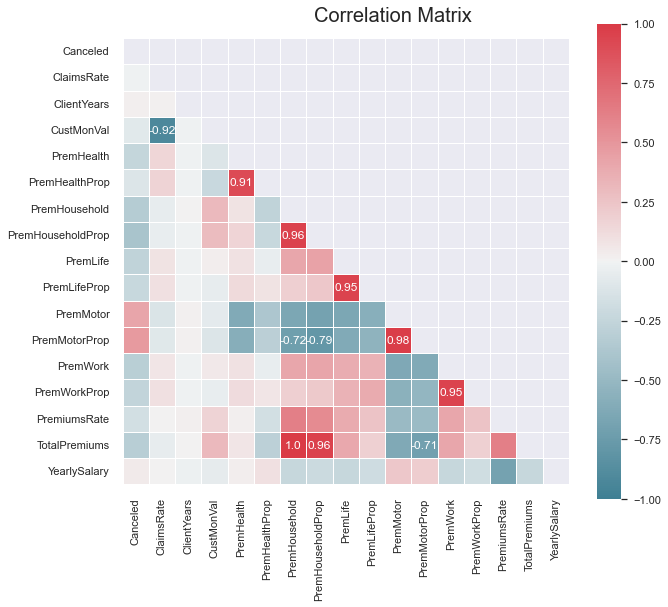

In [294]:
# Prepare figure
metric_features = df_insurance.columns.difference(non_metric_features)
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix
corr = np.round(df_insurance[metric_features].corr(method="pearson"), decimals=2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Build annotation matrix 
mask_annot = np.absolute(corr.values) >= 0.7
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, mask=mask)

# Layout
fig.subplots_adjust(top=0.95)
title = "Correlation Matrix"
fig.suptitle(title, fontsize=20)

plt.show()

TODO: Descrever resultados

# Clustering

Helper Functions

In [295]:
#make a basic kmeans model with a set number of clusters and return its labels and centers locations
def kmeans(df,n_clusters):
    kmeans = KMeans(n_clusters=n_clusters,random_state=23,max_iter=100).fit(df)
    cluster_labels = kmeans.predict(df)
    centers = kmeans.cluster_centers_
    return cluster_labels,centers

In [296]:
#make a gmm model with a set number of components and return its clusters' labels 
def gmm(df,n_components):
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', random_state=23)
    gmm.fit(df)
    clust_labels = gmm.predict(df)
    return(clust_labels)

In [297]:
#plot a dendrogram with a set number of non-singleton clusters and distance metric
def dendrogram_plot(df,metric,n_clusters):
    Z = ward(pdist(df,metric="euclidean"))

    fig = plt.figure(figsize=(15,10))
    dend = dendrogram(Z,truncate_mode="lastp",p=n_clusters)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.ylabel(metric + " distance")

In [298]:
def elbow_method(df):
    metrics = ["distortion","silhouette","calinski_harabasz"]    
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    for metric,ax in zip(metrics,axes):
        model = KMeans()
        visualizer = KElbowVisualizer(
            model, k=(2,10), metric=metric, timings=False, locate_elbow=False, ax=ax
        ).fit(df)
        
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel(metric + " score")
        ax.set_title(metric.capitalize() + " score Elbow for KMeans Clustering")
    plt.show()  

In [299]:
def silhouette_analysis(df,range_n_clusters):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1,figsize=(8,5))

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering with {n_clusters} clusters",
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

In [318]:
def cluster_histograms(df):
    variables = df.columns[:-1]
    colors = ["b","g","r","c","y","m"]
    for i,c in zip(variables,colors):
        g = sns.displot(x=i,
                        col="Cluster",
                        data=df, kind="hist",
                        height=3, aspect=1.5,bins=10,color=c);
        g.tight_layout()
    plt.show()

In [301]:
def show_cluster_sizes(df):
    sns.countplot(data=df,x="Cluster")
    print(df["Cluster"].value_counts())

In [366]:
def visualize_clusters(df):
    
    fig,axes = plt.subplots(1,2,figsize=(18,5))
    df_melt = pd.melt(df.reset_index(),
                          id_vars=['Cluster'],
                          value_vars=df.columns,
                          var_name='Attribute',
                          value_name='Value')
    df_melt.head()# Visualize it
    sns.lineplot(x='Attribute', y='Value',palette="tab10", hue='Cluster', data=df_melt,ax=axes[0])
    
    sns.countplot(data=df,x="Cluster",ax=axes[1],palette="tab10")
    print(df["Cluster"].value_counts())
    
    axes[0].title.set_text('Clusters variable means')
    axes[1].title.set_text('Clusters sizes')
    
    plt.show()

In [376]:
def build_kmeans_clusters(df,nr_clusters):
    kmeans = KMeans(n_clusters=nr_clusters).fit(df)
    prediction = kmeans.predict(df)
    centers = kmeans.cluster_centers_
    df_copy = df.copy()
    df_copy["Cluster"] = pd.Series(prediction, index=df_copy.index)
    return df_copy

### Product Segmentation

#### Proportional values

In [378]:
#The variables that define the actual product being sold, in this case the insurance will be used for the Product Segmentation
df_product_prop = df_insurance.copy()
df_product_prop = df_product_prop[["PremHouseholdProp","PremHealthProp","PremLifeProp","PremMotorProp","PremWorkProp"]]

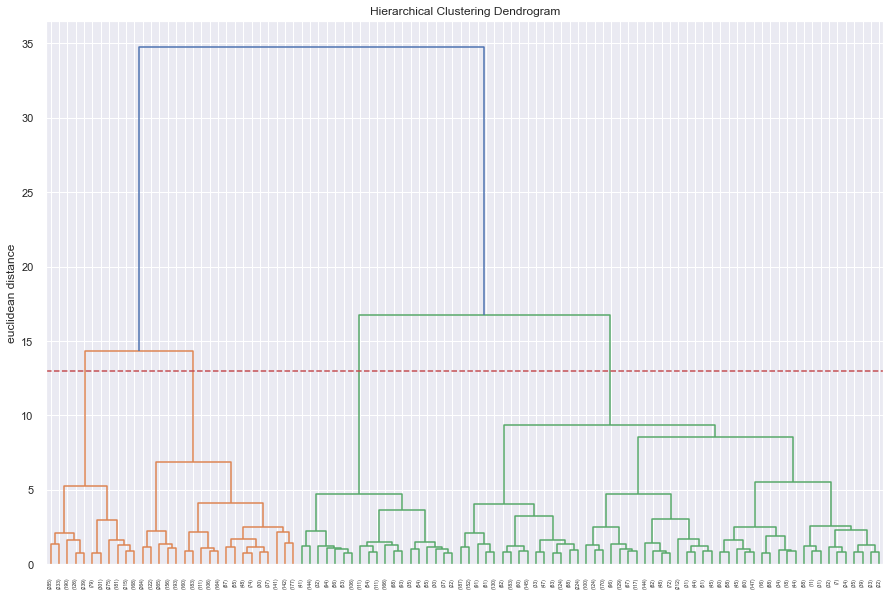

In [304]:
dendrogram_plot(df_product_prop,"euclidean",100)
plt.show()

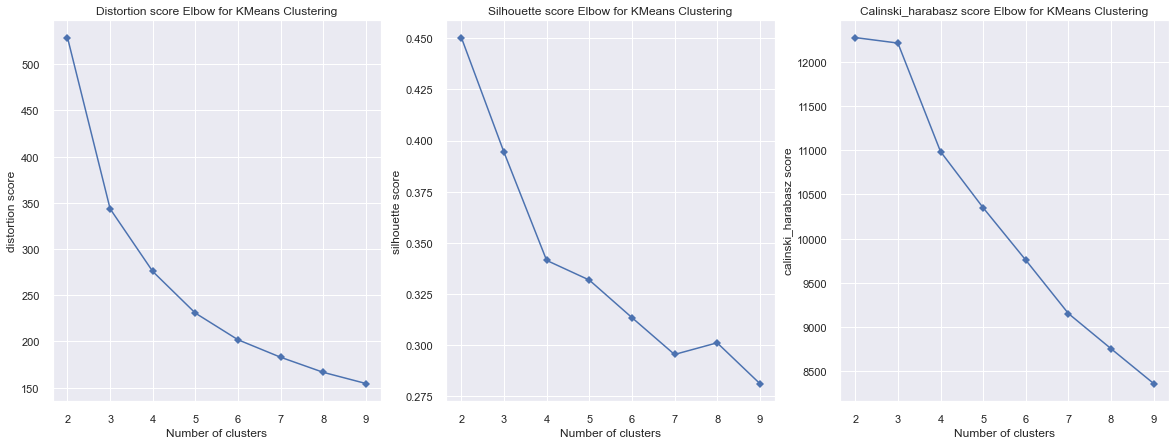

In [305]:
elbow_method(df_product_prop)

For n_clusters = 3 The average silhouette_score is : 0.3941186621818681
For n_clusters = 4 The average silhouette_score is : 0.34120669842451656


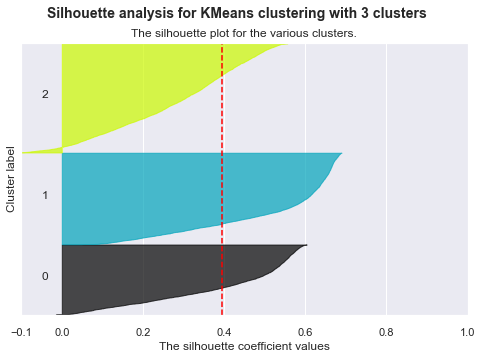

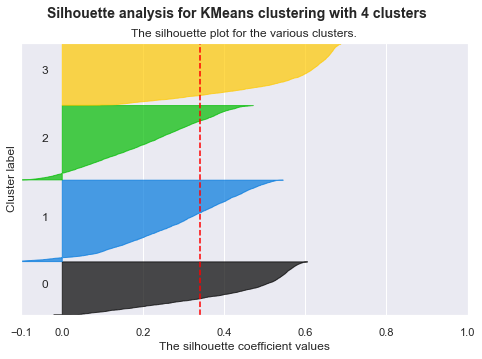

In [306]:
silhouette_analysis(df_product_prop,[3,4])

In [379]:
df_product_prop_3k = build_kmeans_clusters(df_product_prop,3)
df_product_prop_4k = build_kmeans_clusters(df_product_prop,4)

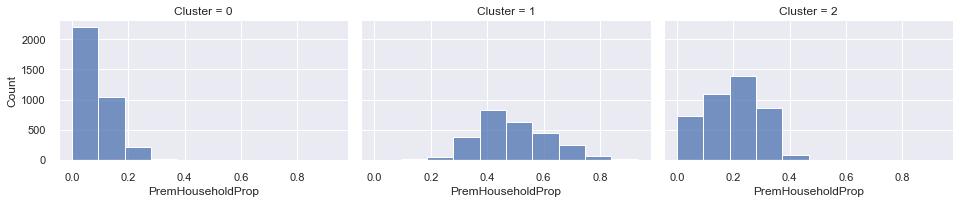

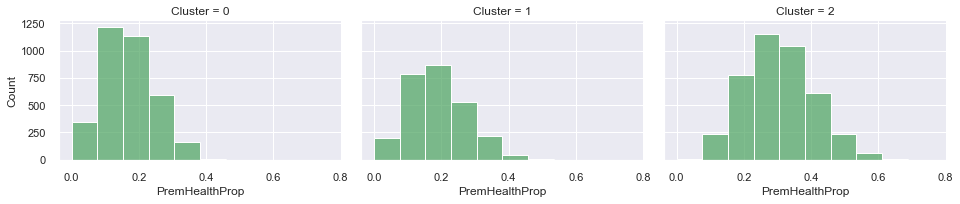

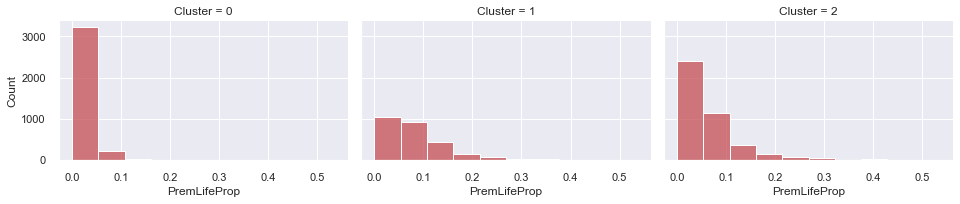

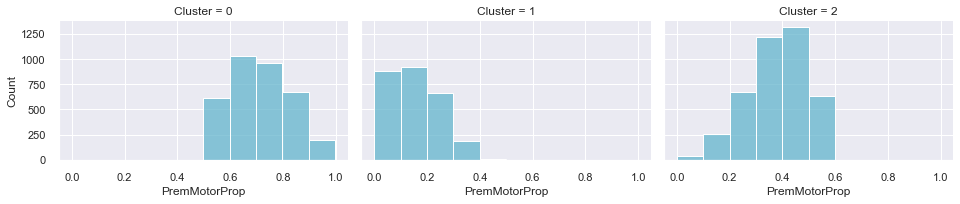

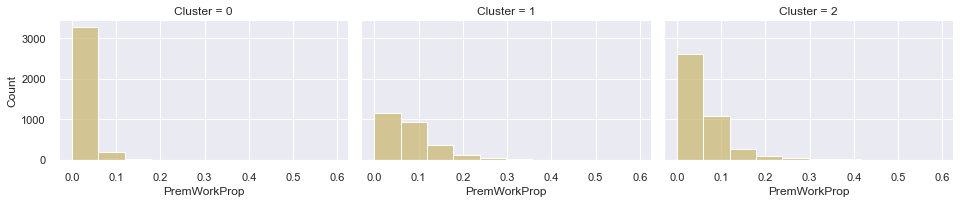

In [371]:
cluster_histograms(df_product_prop_3k)

0    4138
2    3470
1    2655
Name: Cluster, dtype: int64


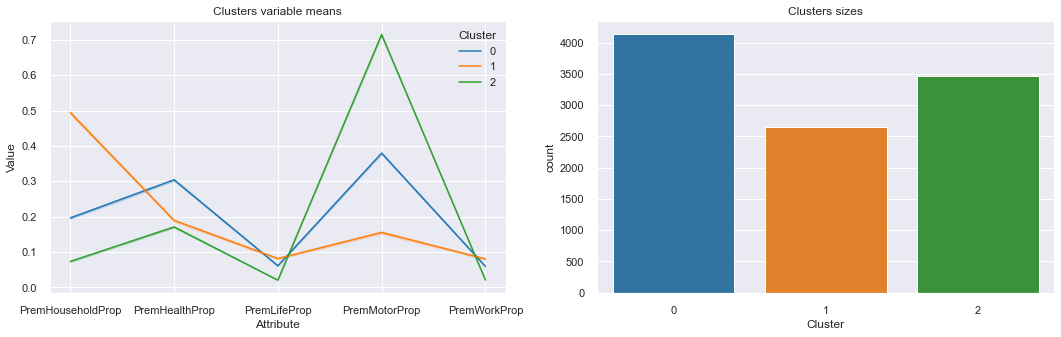

In [380]:
visualize_clusters(df_product_prop_3k)

1    3095
0    2804
3    2336
2    2028
Name: Cluster, dtype: int64


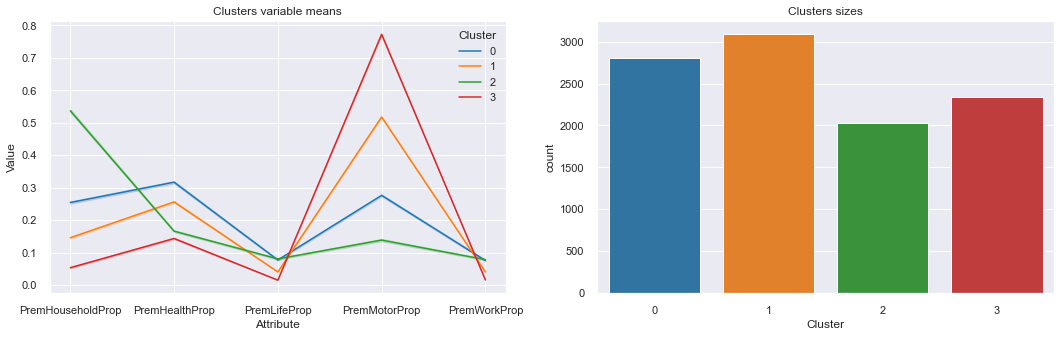

In [381]:
visualize_clusters(df_product_prop_4k)

<AxesSubplot:xlabel='PremHouseholdProp', ylabel='PremMotorProp'>

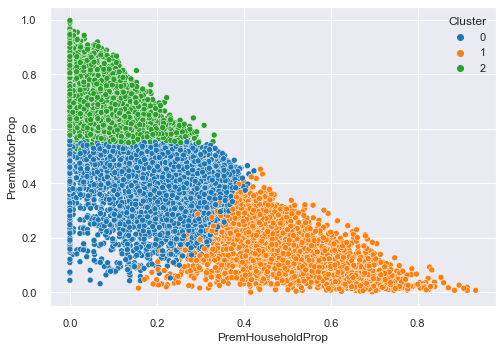

In [382]:
sns.scatterplot(data=df_product_prop_3k, x="PremHouseholdProp", y="PremMotorProp", hue="Cluster",palette="tab10")

<AxesSubplot:xlabel='PremHouseholdProp', ylabel='PremMotorProp'>

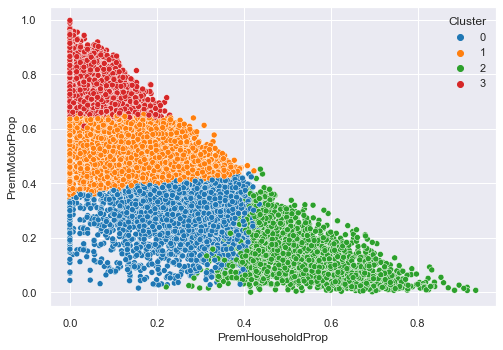

In [383]:
sns.scatterplot(data=df_product_prop_4k, x="PremHouseholdProp", y="PremMotorProp", hue="Cluster",palette="tab10")

3    3093
0    2790
1    2349
2    2031
Name: Cluster, dtype: int64


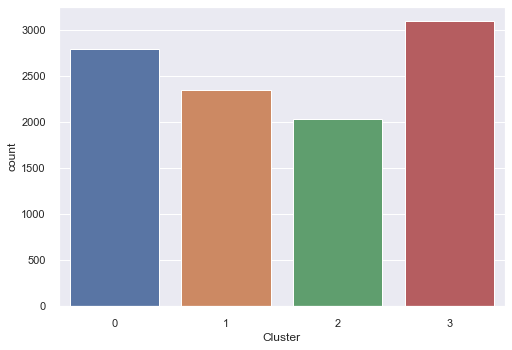

In [326]:
show_cluster_sizes(df_product_prop)

#### Total values

In [384]:
df_product_total = df_insurance.copy()
df_product_total = df_product_total[["PremHealth","PremHousehold","PremLife","PremMotor","PremWork"]]
df_product_total.head()

,PremHealth,PremHousehold,PremLife,PremMotor,PremWork
0,146.36,79.45,47.01,375.85,16.89
1,116.69,416.20,194.48,77.46,106.13
2,124.58,224.50,86.35,206.15,99.02
3,311.17,43.35,35.34,182.48,28.34
4,182.59,47.80,18.78,338.62,41.45


In [385]:
scaler = StandardScaler()
df_product_total = pd.DataFrame(scaler.fit_transform(df_product_total), columns=df_product_total.columns, index=df_product_total.index)
df_product_total.head()

,PremHealth,PremHousehold,PremLife,PremMotor,PremWork
0,-0.291647,-0.539450,0.113925,0.570132,-0.512212
1,-0.692132,0.885602,3.227821,-1.592428,1.395148
2,-0.585633,0.074369,0.944607,-0.659757,1.243183
3,1.932956,-0.692218,-0.132493,-0.831303,-0.267487
4,0.197385,-0.673386,-0.482165,0.300310,0.012718


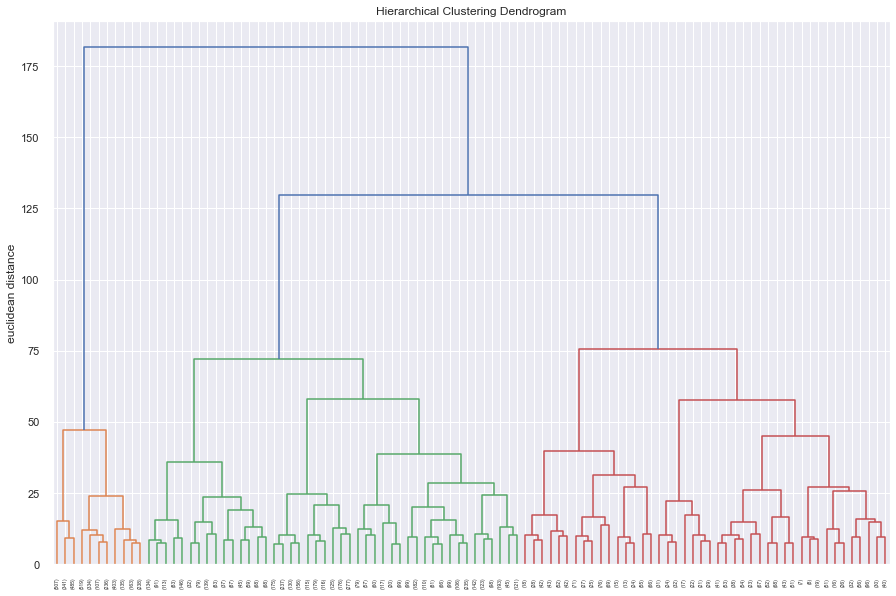

In [386]:
dendrogram_plot(df_product_total,"euclidean",100)

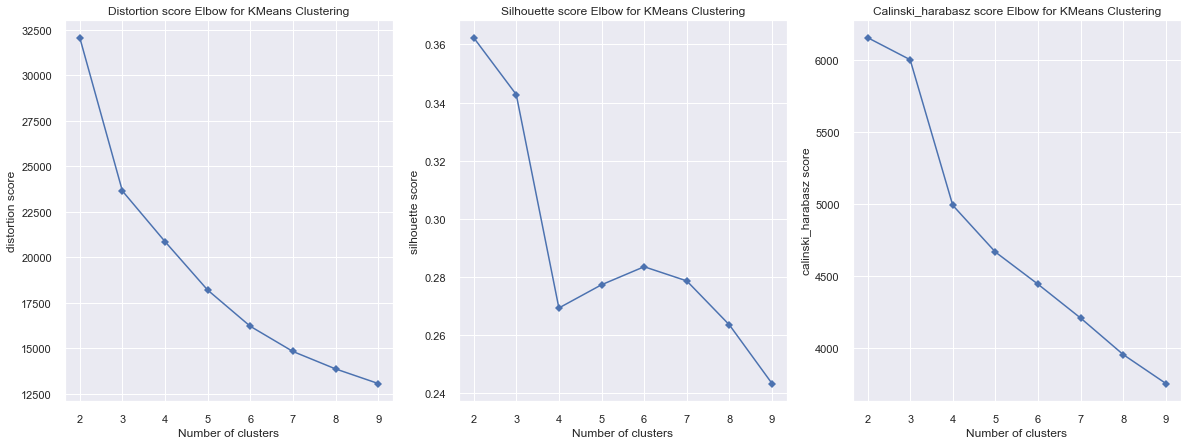

In [387]:
elbow_method(df_product_total)

For n_clusters = 3 The average silhouette_score is : 0.3425503833113306
For n_clusters = 4 The average silhouette_score is : 0.269352795085353


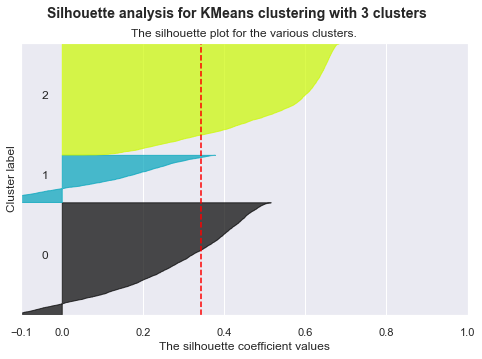

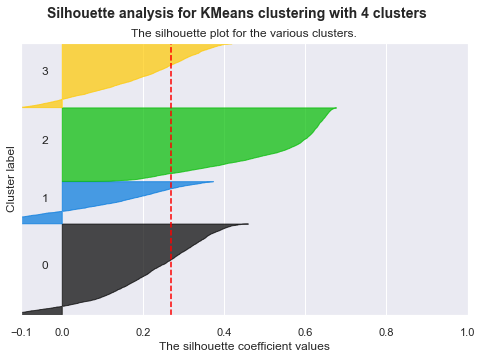

In [392]:
silhouette_analysis(df_product_total,[3,4])

In [388]:
df_product_total_3k = build_kmeans_clusters(df_product_total,3)

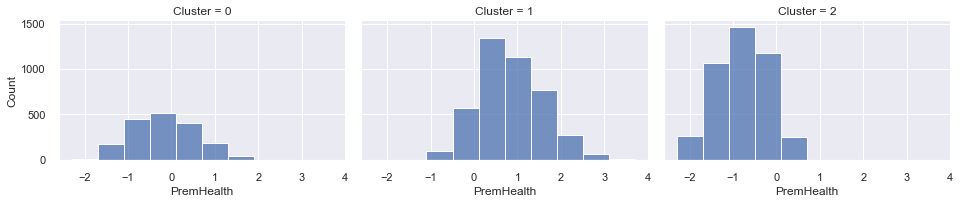

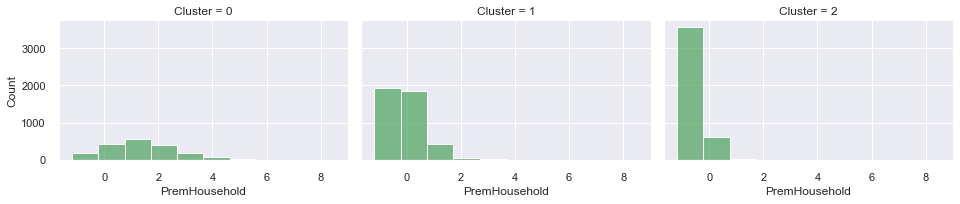

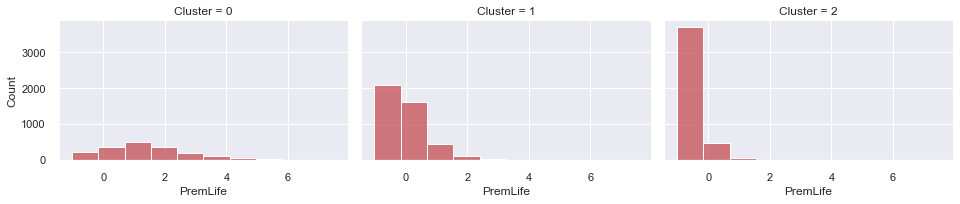

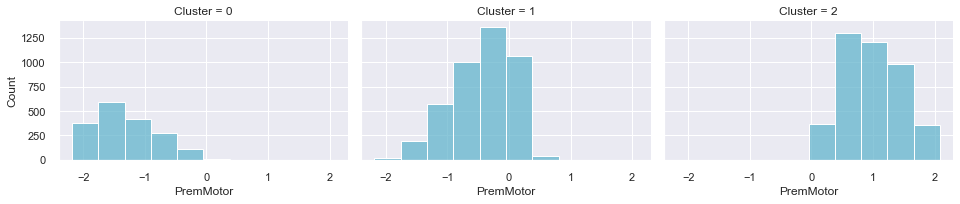

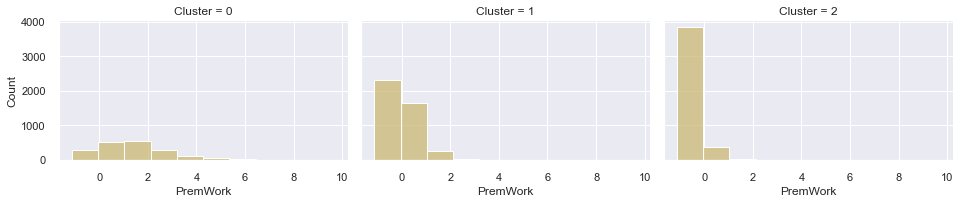

In [389]:
cluster_histograms(df_product_total_3k)

1    4256
2    4219
0    1788
Name: Cluster, dtype: int64


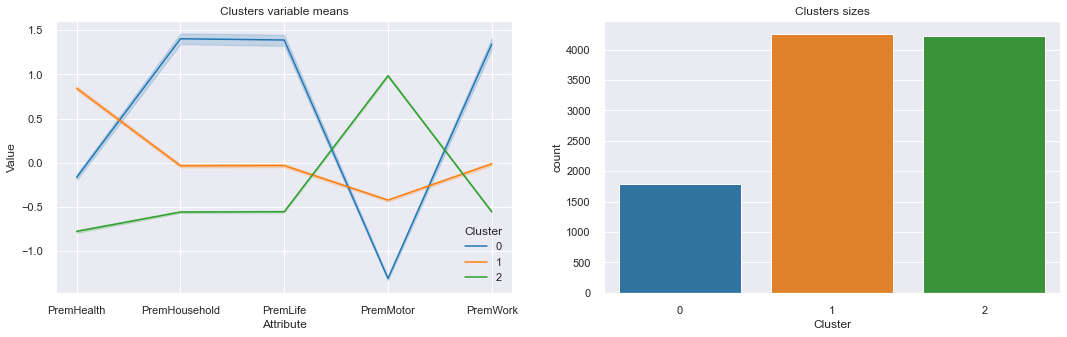

In [391]:
visualize_clusters(df_product_total_3k)